In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt
from bm3d import bm3d_rgb, BM3DProfile
import sys
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/bm3d-4.0.3/bm3d-4.0.3/examples" 
sys.path.insert(0, module_dir)
from experiment_funcs import get_experiment_noise, get_psnr, get_cropped_psnr
from PIL import Image
import math
import torch
import torch.nn as nn
import torch.optim as optim
from thop import profile
from einops import rearrange 
from einops.layers.torch import Rearrange, Reduce
from timm.models.layers import trunc_normal_, DropPath

module_dir_scu = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/SCUNet" 
sys.path.insert(0, module_dir_scu)
from models.network_scunet import SCUNet as SCUNet
from torch.utils.data import Dataset
from utils import utils_image as util
import joblib
from sklearn.preprocessing import MinMaxScaler

2025-07-31 11:23:29.763337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753986209.777625 1952805 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753986209.781849 1952805 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753986209.793873 1952805 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753986209.793893 1952805 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753986209.793894 1952805 computation_placer.cc:177] computation placer alr

In [2]:

with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    ref_d = file['density'][:]

In [19]:
#### test file #######
with h5py.File('/pscratch/sd/k/kberard/SCGSR/Data/diamond_1x1x1_bfd/density_data/vmc_J2/density_tot_vmc_mean_0000655360.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    test_d = file['density'][:]

In [4]:
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)

In [5]:
def encode_voxel_to_rgb(test_d, save_path='slice_scalers.npz'):
    """
    Normalize each XY slice independently and encode to RGB (repeated channels).
    Saves (min, max) for each slice for reconstruction.
    
    Returns:
        rgb_volume: (64, 64, 64, 3)
    """
    rgb_volume = np.zeros((64, 64, 64, 3), dtype=np.float32)
    mins = []
    maxs = []

    for i in range(64):
        slice_2d = test_d[i, :, :]
        s_min = float(slice_2d.min())
        s_max = float(slice_2d.max())

        if s_max == s_min:
            s_max = s_min + 1e-6  # Avoid divide-by-zero for flat slices

        normed = (slice_2d - s_min) / (s_max - s_min)
        rgb_volume[i, :, :, :] = np.stack([normed]*3, axis=-1)  # (64, 64, 3)

        mins.append(s_min)
        maxs.append(s_max)

    np.savez(save_path, mins=np.array(mins), maxs=np.array(maxs))
    return rgb_volume  # shape: (64, 64, 64, 3)


In [6]:
def decode_rgb_to_voxel(rgb_volume, save_path='slice_scalers.npz'):
    """
    Decode per-slice normalized RGB volume back into scalar 3D volume.
    Assumes all RGB channels are identical.
    
    Args:
        rgb_volume: shape (64, 64, 64, 3)
    """
    data = np.load(save_path)
    mins = data['mins']
    maxs = data['maxs']

    test_d = np.zeros((64, 64, 64), dtype=np.float32)

    for i in range(64):
        rgb_slice = rgb_volume[i]  # (64, 64, 3)
        gray = rgb_slice[:, :, 0]
        restored = gray * (maxs[i] - mins[i]) + mins[i]
        test_d[i] = restored

    return test_d


In [7]:


rgb_encoded = encode_voxel_to_rgb(test_d)
reconstructed = decode_rgb_to_voxel(rgb_encoded)

print("Max error:", np.abs(test_d - reconstructed).max())
print("All close:", np.allclose(test_d, reconstructed, atol=1e-6))


Max error: 2.3283064387071006e-11
All close: True


In [8]:
print(reconstructed.shape)
print(rgb_encoded.shape)

(64, 64, 64)
(64, 64, 64, 3)


In [9]:
############### scunet_Pretrained ###############

In [10]:
############### scunet_Trained ###############

In [11]:
############## scunet_TL ##################

In [12]:
############# Nature #####################

In [13]:
############### CAE_img_enc ###############

In [14]:
################# CAE_full_3D #############


[ENCODE/DECODE DEBUG] Max reconstruction error BEFORE BM3D: 0.000000
All close: True


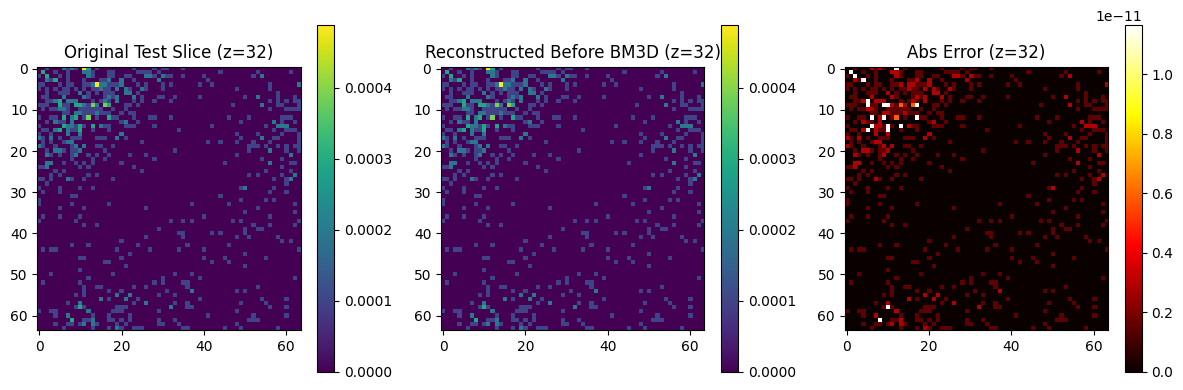

In [15]:
# Check reversibility BEFORE denoising
reconstructed_test_d = decode_rgb_to_voxel(rgb_encoded)

# Compute error
error = np.abs(test_d - reconstructed_test_d)
max_error = np.max(error)
print(f"\n[ENCODE/DECODE DEBUG] Max reconstruction error BEFORE BM3D: {max_error:.6f}")
print(f"All close: {np.allclose(test_d, reconstructed_test_d)}")

# Plot one slice for visual confirmation
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(test_d[32], cmap='viridis')
plt.title("Original Test Slice (z=32)")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_test_d[32], cmap='viridis')
plt.title("Reconstructed Before BM3D (z=32)")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(error[32], cmap='hot')
plt.title("Abs Error (z=32)")
plt.colorbar()
plt.tight_layout()
plt.show()


In [20]:
from bm3d import bm3d
def bm3d_test_pipeline(test_d, ref_d):
    # Encode
    test_rgb = encode_voxel_to_rgb(test_d)
    ref_rgb  = encode_voxel_to_rgb(ref_d)

    # Denoise each of 64 RGB slices
    denoised_rgb = np.zeros_like(test_rgb)
    N = 100
    sigma = np.sqrt(1.0 / N)
    print("here")
    print(test_rgb.shape)



    #######
    for i in range(64):
        noisy_slice = test_rgb[i]

        gray_input = noisy_slice[:, :, 0]  # just one channel
        denoised_gray = bm3d(gray_input, sigma_psd=sigma)
        denoised_rgb[i] = np.stack([denoised_gray] * 3, axis=-1)

    ####

    # Reconstruct full 3D volume
    denoised_d = decode_rgb_to_voxel(denoised_rgb)

    # --- Evaluation ---
    print("\n>>> Evaluation Metrics")
    jsd_noisy = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(test_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )
    jsd_denoised = jensen_shannon_divergence_loss(
        tf.convert_to_tensor(denoised_d, dtype=tf.float32),
        tf.convert_to_tensor(ref_d, dtype=tf.float32)
    )

    norm_noisy = np.linalg.norm(test_d - ref_d)
    norm_denoised = np.linalg.norm(denoised_d - ref_d)

    print(f"2-norm (noisy vs ref):     {norm_noisy:.4f}")
    print(f"2-norm (denoised vs ref): {norm_denoised:.4f}")
    print(f"JSD   (noisy vs ref):     {jsd_noisy.numpy():.6f}")
    print(f"JSD   (denoised vs ref):  {jsd_denoised.numpy():.6f}")

    # --- Plot example slices ---
    slice_idx = 32
    plt.figure(figsize=(12, 6))
    titles = ['Noisy', 'Denoised', 'Reference']
    data = [test_d[slice_idx], denoised_d[slice_idx], ref_d[slice_idx]]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(data[i], cmap='viridis')
        plt.title(f"{titles[i]} (z={slice_idx})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

here
(64, 64, 64, 3)

>>> Evaluation Metrics
2-norm (noisy vs ref):     0.0037
2-norm (denoised vs ref): 0.0045
JSD   (noisy vs ref):     0.008134
JSD   (denoised vs ref):  0.003858


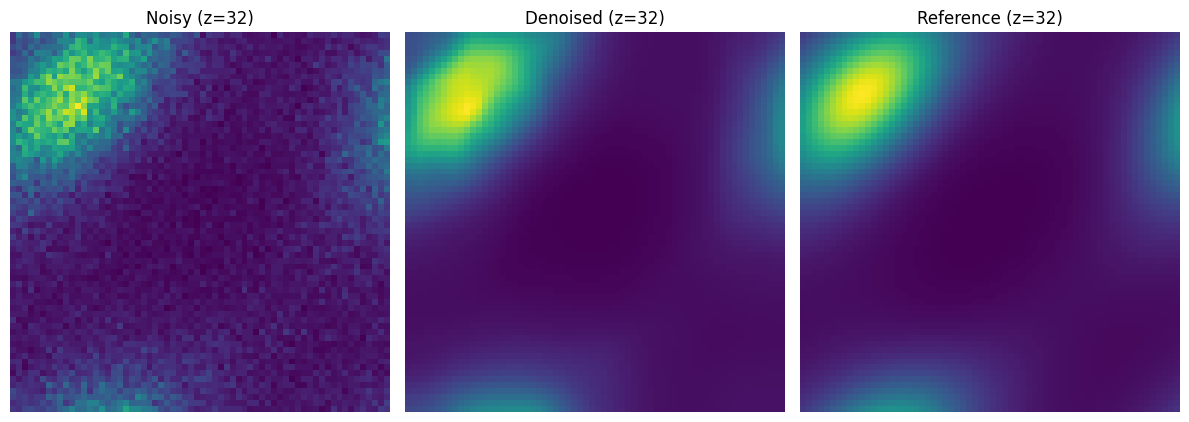

In [21]:
# Simulated test
np.random.seed(42)
bm3d_test_pipeline(test_d, ref_d)
